**MACS205a - Projet équations différentielles**

*Encadrant*: Olivier FERCOQ

*Membres du groupe:*
- *ABUBAKER Rita*
- *BERRONDO Alice*
- *LY Timothée*
- *PERSONNAZ Louis*
- *TOURTOIS Eliott*
- *WINTER Alexis*

# Imports

In [155]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_palette("hls")
from IPython.display import Image
from scipy.integrate import odeint, solve_ivp

# Problème

Sur [ce site](https://exchange.iseesystems.com/public/globeprogam/global-carbon-cycle-model-with-feedbacks/index.html), on trouve un simulateur du cycle du carbone. Les paramètres du modèle et les équations d'évolution ci-dessous (sous forme mathématique et de fonctions Python) y sont tirés. Toutefois, les méthodes numériques employées sont inconnues. On se propose donc ici de faire notre propre analyse et de tirer nos propres conclusions sur les résultats, à partir du modèle donné.

Voici une carte visuelle du modèle donnée par ISEE Systems :

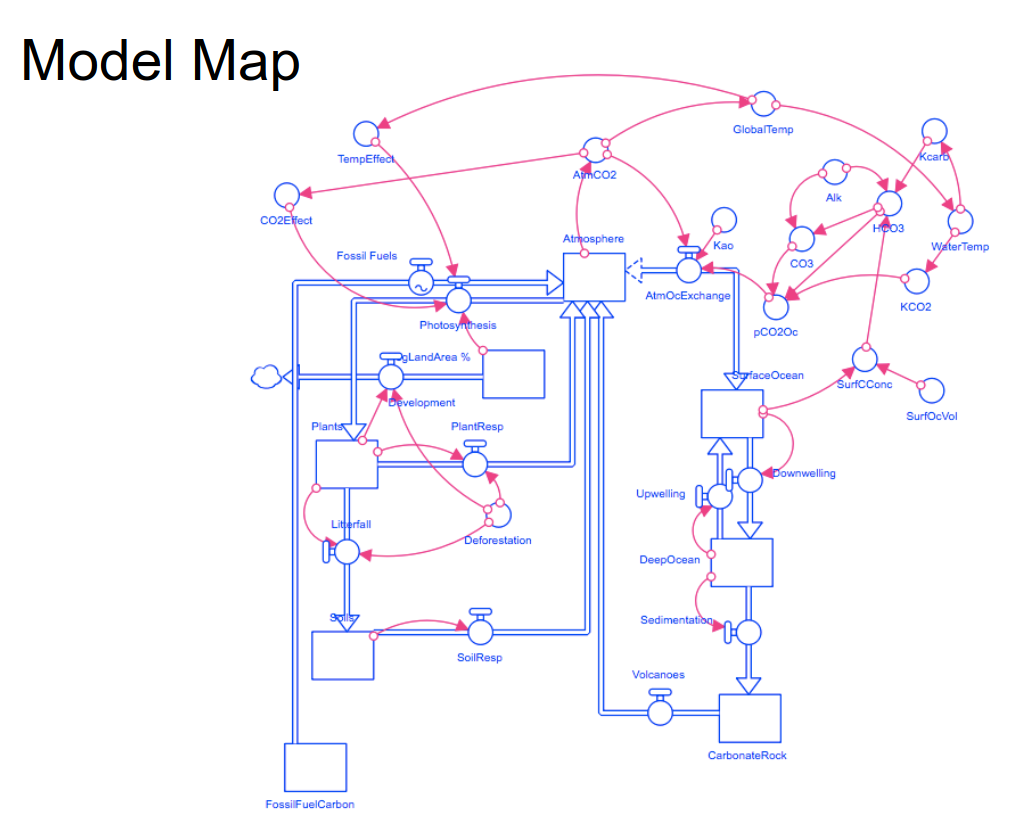

In [8]:
Image("model_map.png", width=800, embed=True)

# Formalisation théorique

On vectorialise le problème ainsi grâce aux équations données :

$$\begin{bmatrix} 
    y_0 \\
    y_1 \\
    y_2 \\
    y_3 \\
    y_4 \\
    y_5 \\
    y_6 \\
    y_7
\end{bmatrix} = \begin{bmatrix} 
    Atmosphere \\
    CarbonateRock \\
    DeepOcean\\
    FossilFuel \\
    Plant \\
    Soil \\
    SurfaceOcean \\
    VegLandAreaPercent
\end{bmatrix}$$

$$\begin{bmatrix} 
    y_0 \\
    y_1 \\
    y_2 \\
    y_3 \\
    y_4 \\
    y_5 \\
    y_6 \\
    y_7
\end{bmatrix} [0] = \begin{bmatrix} 
    Atmosphere\_Initial \\
    CarbonateRock\_Initial \\
    DeepOcean\_Initial \\
    FossilFuel\_Initial \\
    Plant\_Initial \\
    Soil\_Initial \\
    SurfaceOcean\_Initial \\
    VegLandAreaPercent\_Initial
\end{bmatrix}$$

$$\begin{bmatrix} 
    y_0' \\
    y_1' \\
    y_2' \\
    y_3' \\
    y_4' \\
    y_5' \\
    y_6' \\
    y_7'
\end{bmatrix} (t) =
\begin{bmatrix}
    Kao*\frac{280}{y_0[0]}  & 0 & 0 & 0 & \frac{55}{y_4[0]} & \frac{55}{y_5[0]} & 0 & 0 \\
    0       & 0 & \frac{0,1} {y_2[0]} & 0 &0 &0 &0 & 0 \\
    0       & 0 & 0 & \frac {90,1} {y_3[0]} &0 &0 & \frac {90,1} {y_6[0]} & 0 \\
    0       & 0 & 0 & 0 &0 &0 &0 & 0 \\
    \frac {30800} {y_0[0]} &0 &0 &0 &\frac{55}{y_4[0]} & 0 & 0 &0 \\                                         
    0 &0 &0 &0 &\frac{55}{y_4[0]} & - \frac{55}{y_5[0]} & 0 &0 \\
    Kao \times \frac{280}{y_0[0]} &0 &\frac{90}{y_2[0]} &0 &0 &0 &- \frac{90.1}{y_6[0]} &0      \\
    0 &0 &0 &0 &0 &0 &0 &0  
\end{bmatrix} \times \begin{bmatrix} 
    y_0 \\
    y_1 \\
    y_2 \\
    y_3 \\
    y_4 \\
    y_5 \\
    y_6 \\
    y_7
\end{bmatrix} (t) + \begin{bmatrix} 
    Deforestation + 0.1 + FFC - Photosynthesis - Kao*pC02Oc\\
    -Volcanoes \\
    0 \\
    -FossilFuelsCombustion \\
    0 \\
    \frac{Deforestation}{2} \\
    -Ka_0*pCO2Oc \\
    - 20 \frac{Deforestation}{y_4[0]}
\end{bmatrix}$$

On note que $y_0$ et $y_6$ sont non linéaires comme ils dépendent de $pCO2Oc = 280 * (0,035+0,0019*(10+0,01*(\frac {280 *y_0}{y_0[0]} -280)))  * \frac {HCO3^2}{CO3}$ qui dépend de $HCO3 = \frac {y_6}{12000 * SurfOcVol} - \sqrt{(\frac {y_6}{12000 * SurfOcVol})^2 - Alk*(2*\frac {y_6}{12000 * SurfOcVol} -Alk) * (1-4*KCarb)}*\frac 1 {1-4 KCarb}$ avec $KCarb=0,000575 + 0,000006*(10+ (\frac {y_0*280} {y_0[0]})*0,01)$ dépendant lui même de $y_0$ et $y_6$.

En voyant $y_0$ et $y_6$ comme des fonctions "boîtes noires" cachées mais connues, on peut réécrire le problème ainsi :

$$\begin{bmatrix} 
    y_1' \\
    y_2' \\
    y_3' \\
    y_4' \\
    y_5' \\
    y_7'
\end{bmatrix} (t) =
\begin{bmatrix}
    0       & 0 & \frac{0,1} {y_2[0]} & 0 &0 &0 &0 & 0 \\
    0       & 0 & 0 & \frac {90,1} {y_3[0]} &0 &0 & \frac {90,1} {y_6[0]} & 0 \\
    0       & 0 & 0 & 0 &0 &0 &0 & 0 \\
    \frac {30800} {y_0[0]} &0 &0 &0 &\frac{55}{y_4[0]} & 0 & 0 &0 \\                                         
    0 &0 &0 &0 &\frac{55}{y_4[0]} & - \frac{55}{y_5[0]} & 0 &0 \\
    0 &0 &0 &0 &0 &0 &0 &0  
\end{bmatrix} \times \begin{bmatrix} 
    y_1 \\
    y_2 \\
    y_3 \\
    y_4 \\
    y_5 \\
    y_7
\end{bmatrix} (t) + \begin{bmatrix}
    -v \\
    \frac{90,1}{y_6[0]} y_6(t) \\
    -\varphi(t) \\
    \frac{30800}{y_0[0]} y_0(t) \\
    \frac{d}{2} \\
    - 20 \frac{d}{y_4[0]}
\end{bmatrix}$$

i.e.

$$y'(t) = A y(t) + b(t) = f(t, y(t))$$

avec
$$
f \, \colon \,
\begin{align*}
  \mathbb{R} \times \mathbb{R}^6 &\to \mathbb{R}^6 \\
  (t, y) &\mapsto A y + b(t).
\end{align*}
$$

et où $d = Deforestation$, $v = Volcanoes$ sont des constantes et $\varphi(t)$ est la combustion de carburants fossiles au temps $t$.

$A$ est une fonction continue (c'est une matrice constante dépendant uniquement des conditions initiales). $b$ est également continue sous l'hypothèse que $y_0$, $y_6$ et $\varphi$ le sont, hypothèse que l'on peut faire puisque elle est assez faible. Ainsi $f$ est continue en $t$ et en $y$.

Le théorème de Cauchy-Lipschitz s’applique et donc le problème de Cauchy a une unique solution.

# Code

In [48]:
# Initial conditions
Atmosphere_Initial          = 750
CarbonateRock_Initial       = 100000000
DeepOcean_Initial           = 38000
FossilFuel_Initial          = 7500
Plant_Initial               = 560
Soil_Initial                = 1500
SurfaceOcean_Initial        = 890
VegLandArea_percent_Initial = 100

# Constants
Alk = 2.222446077610055
Kao = .278
SurfOcVol = .0362
Deforestation = 1.0

# Fossil fuel
FossFuelData = np.array([[50.0, 0.00],
                         [75.0, 0.30],
                         [100.0, 0.60],
                         [125.0, 1.35],
                         [150.0, 2.85],
                         [175.0, 4.95],
                         [200.0, 7.20],
                         [225.0, 10.05],
                         [250.0, 14.85],
                         [275.0, 20.70],
                         [300.0, 30.00]])

In [49]:
# Helper functions
def AtmCO2(Atmosphere):
    return Atmosphere * (280/Atmosphere_Initial)
def GlobalTemp(AtmCO2):
    return 15 + ((AtmCO2-280) * .01)
def CO2Effect(AtmCO2):
    return 1.5 * ((AtmCO2) - 40) / ((AtmCO2) + 80)
def WaterTemp(GlobalTemp):
    return 273+GlobalTemp
def TempEffect(GlobalTemp):
    return ((60 - GlobalTemp) * (GlobalTemp + 15)) / (((60 + 15) / 2) ** (2))/.96
def SurfCConc(SurfaceOcean):
    return (SurfaceOcean/12000)/SurfOcVol
def Kcarb(WaterTemp):
    return .000575+(.000006*(WaterTemp-278))
def KCO2(WaterTemp):
    return .035+(.0019*(WaterTemp-278))
def HCO3(Kcarb, SurfCConc):
    return(SurfCConc-(np.sqrt(SurfCConc**2-Alk*(2*SurfCConc-Alk)*(1-4*Kcarb))))/(1-4*Kcarb)
def CO3(HCO3):
    return (Alk-HCO3)/2
def pCO2Oc(KCO2, HCO3, CO3):
    return 280*KCO2*(HCO3**2/CO3)

def FossilFuelsCombustion(t):
    i = 0
    if t >= FossFuelData[-1,0]:
        return FossFuelData[-1,1]
    while i + 1 < len(FossFuelData) and t >= FossFuelData[i,0]:
        i = i + 1
    if i == 0:
        return FossFuelData[0,1]
    else:
        return (FossFuelData[i-1,1]
             + (t - FossFuelData[i-1,0]) / (FossFuelData[i,0] - FossFuelData[i-1,0]) * (FossFuelData[i,1] - FossFuelData[i-1,1]))

def derivative(y, t):
    Atmosphere          = y[0]
    CarbonateRock       = y[1]
    DeepOcean           = y[2]
    FossilFuelCarbon    = y[3]
    Plants              = y[4]
    Soils               = y[5]
    SurfaceOcean        = y[6]
    VegLandArea_percent = y[7]

    PlantResp = (Plants * (55/Plant_Initial)) + Deforestation/2
    Litterfall = (Plants* (55/Plant_Initial)) + (Deforestation/2)
    SoilResp = Soils * (55/Soil_Initial)
    Volcanoes = 0.1
    AtmCO2_ = AtmCO2(Atmosphere)
    GlobalTemp_ = GlobalTemp(AtmCO2_)
    WaterTemp_ = WaterTemp(GlobalTemp_)
    Photosynthesis = 110 * CO2Effect(AtmCO2_) * (VegLandArea_percent/100) * TempEffect(GlobalTemp_)
    HCO3_ = HCO3(Kcarb(WaterTemp_), SurfCConc(SurfaceOcean))
    pCO2Oc_ = pCO2Oc(KCO2(WaterTemp_), HCO3_, CO3(HCO3_))
    AtmOcExchange = Kao*(AtmCO2_-pCO2Oc_)
    if y[3] > 0:
        FossilFuelsCombustion_ = FossilFuelsCombustion(t)
    else:
        FossilFuelsCombustion_ = 0
    dAtmosphere_dt = (PlantResp
                    + SoilResp
                    + Volcanoes
                    + FossilFuelsCombustion_
                    - Photosynthesis
                    - AtmOcExchange)

    Sedimentation = DeepOcean * (0.1/DeepOcean_Initial)
    dCarbonateRock_dt = Sedimentation - Volcanoes

    Downwelling = SurfaceOcean*(90.1/SurfaceOcean_Initial)
    Upwelling = DeepOcean * (90/DeepOcean_Initial)
    dDeepOcean_dt = Downwelling - Sedimentation - Upwelling

    dFossilFuelCarbon_dt = - FossilFuelsCombustion_

    dPlants_dt = Photosynthesis - PlantResp - Litterfall

    dSoils_dt = Litterfall - SoilResp

    dSurfaceOcean_dt = Upwelling + AtmOcExchange - Downwelling

    Development = (Deforestation/Plant_Initial * 0.2) * 100
    dVegLandArea_percent_dt = - Development

    derivative = np.array([
        dAtmosphere_dt,
        dCarbonateRock_dt,
        dDeepOcean_dt,
        dFossilFuelCarbon_dt,
        dPlants_dt,
        dSoils_dt,
        dSurfaceOcean_dt,
        dVegLandArea_percent_dt
    ])

    return derivative

In [117]:
class Model():
    """Represents a model for the carbon cycle"""
    
    def __init__(self, initial_conditions):
        self.initial_conditions = initial_conditions
        self.attr = {0: "Atmosphere",
                     1: "CarbonateRock",
                     2: "DeepOcean",
                     3: "FossilFuel",
                     4: "Plant",
                     5: "Soil",
                     6: "SurfaceOcean",
                     7: "VegLandArea_percent"}
        self.params  = list(self.attr.values())
        self.message = None
        self.success = None
        self.t       = None
        self.y       = None
        
    def predict(self, method_, startYear, endYear, *args, **kwargs):
        if method_ == "solve_ivp":
            t_span = (startYear, endYear)
            derivative_ = lambda t, y: derivative(y, t) # invert the order of the arguments for solve_ivp
            res = solve_ivp(fun=derivative_, t_span=t_span, y0=self.initial_conditions, *args, **kwargs)
            self.message, self.success, self.t, self.y = res.message, res.success, res.t, res.y
        if method_ == "RK4":
            self.message, self.success = None, None
            self.t = np.linspace(startYear, endYear, num=kwargs["num"])
            self.y = rungeKutta4(f=derivative, y0=self.initial_conditions, t=self.t).T # transpose for plot
        if method_ == "RK2":
            self.message, self.success = None, None
            self.t = np.linspace(startYear, endYear, num=kwargs["num"])
            self.y = rungeKutta2(f=derivative, y0=self.initial_conditions, t=self.t).T # transpose for plot
        if method_ == "RK1":
            self.message, self.success = None, None
            self.t = np.linspace(startYear, endYear, num=kwargs["num"])
            self.y = rungeKutta1(f=derivative, y0=self.initial_conditions, t=self.t).T # transpose for plot
    
    def plot_evolution(self, params, title=None, figsize=None):
        if figsize is None: # adaptative figure size
            width = 20
            height = 5 * (1 + ((len(params)-1) // 3))
            figsize = (width, height)
        total = len(params)
        cols = 3
        rows = total // cols
        rows += total % cols
        position = range(1, total+1)
        fig = plt.figure(figsize=figsize)
        fig.suptitle(title, y=0.925)
        for k in range(total):
            ax = fig.add_subplot(rows, cols, position[k]) # create subplot at the right position
            idx = self.params.index(params[k]) # get index of attribute
            ax.plot(self.t, self.y[idx]) # plot evolution
            ax.set_xlabel("Time (years)")
            ax.set_ylabel(f"{params[k]}")
        plt.show()

In [118]:
def rungeKutta4(f, y0, t):
    """
    Performs the explicit Runge-Kutta method of order 4
    params:
    f: 2-params derivative function
    y0: initial condition
    t: array of times
    """
    n = t.size
    y = np.zeros((n, y0.size))
    y[0] = y0
    for i in range(n-1):
        h = t[i+1] - t[i]
        
        p1 = f(y[i], t[i])
        t2 = t[i] + 1/2 * h
        y2 = y[i] + 1/2 * h * p1
        
        p2 = f(y2, t2)
        t3 = t2
        y3 = y[i] + 1/2 * h * p2
        
        p3 = f(y3, t3)
        t4 = t[i] + h 
        y4 = y[i] + h * p3
        
        p4 = f(y4, t4)
        
        y[i+1] = y[i] + h * (p1/6 + 2*p2/6 + 2*p3/6 + p4/6)
    
    return y

In [119]:
def rungeKutta2(f, y0, t):
    """
    Performs the explicit Runge-Kutta method of order 2
    params:
    f: 2-params derivative function
    y0: initial condition
    t: array of times
    """
    n = t.size
    y = np.zeros((n, y0.size))
    y[0] = y0
    
    for i in range(n - 1):
        h = t[i+1] - t[i]
        
        p1 = f(y[i], t[i])
        t2 = t[i] + 1/2 * h
        y2 = y[i] + 1/2 * h * p1
        
        p2 = f(y2, t2)
        
        y[i+1] = y[i] + h * (p1/2 + p2/2)
    return y

In [120]:
def rungeKutta1(f, y0, t):
    """
    Performs the explicit Runge-Kutta method of order 1
    aka Euler's explicit method
    params:
    f: 2-params derivative function
    y0: initial condition
    t: array of times
    """
    n = t.size
    y = np.zeros((n, y0.size))
    y[0] = y0
    
    for i in range(n - 1):
        h = t[i+1] - t[i]
        p1 = f(y[i], t[i])
        
        y[i+1] = y[i] + (t[i+1] - t[i]) * p1
    return y

In [121]:
initial_conditions = np.array([Atmosphere_Initial,
                               CarbonateRock_Initial,
                               DeepOcean_Initial,
                               FossilFuel_Initial,
                               Plant_Initial,
                               Soil_Initial,
                               SurfaceOcean_Initial,
                               VegLandArea_percent_Initial])
model = Model(initial_conditions)

# Prédictions

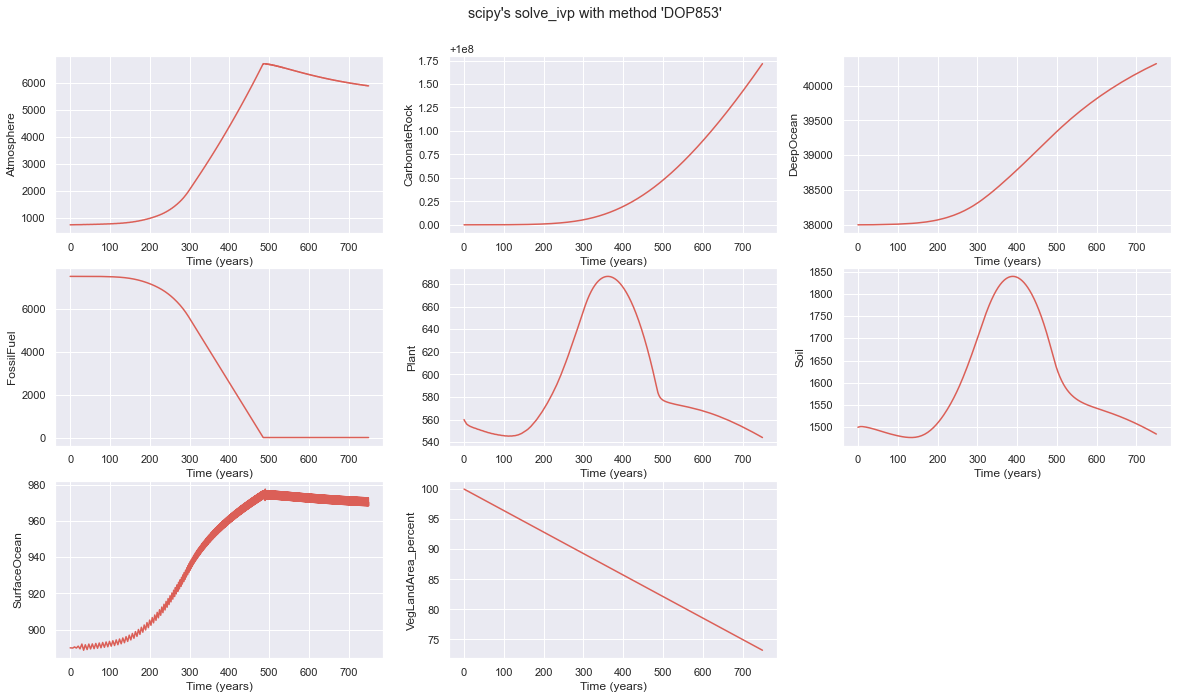

In [122]:
model.predict("solve_ivp", 0, 750, method="DOP853")
model.plot_evolution(model.params, title="scipy's solve_ivp with method 'DOP853'")

> On note ici que la méthode `DOP853` (Runge-Kutta explicite à l'ordre 8) de `scipy.integrate.solve_ivp` a du mal à estimer `SurfaceOcean` (c'était $y_6$) à cause de la non linéarité. Pour `Atmosphere` ($y_0$) le résultat a l'air correct.

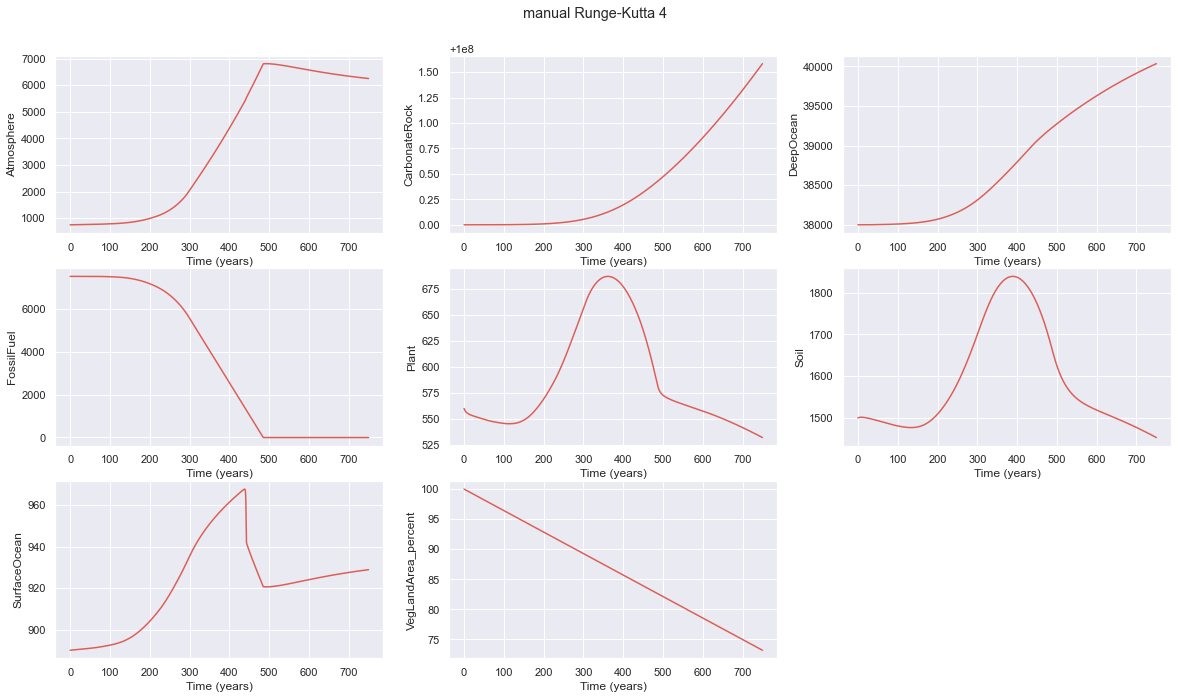

In [123]:
model.predict("RK4", 0, 750, num=3000)
model.plot_evolution(model.params, title="manual Runge-Kutta 4")

> Les résultats avec Runge-Kutta 4 manuel sont similaires pour la majorité des paramètres. Pour `SurfaceOcean` par contre, le comportement après la cassure (année 450 environ) est très différent !

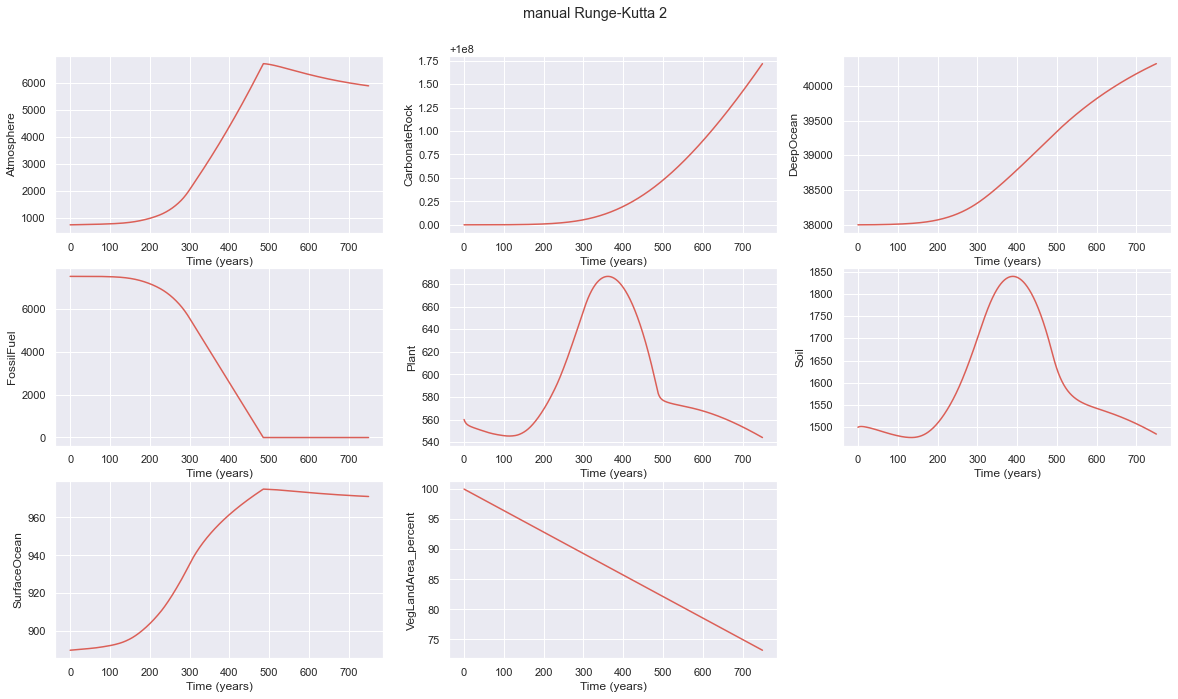

In [124]:
model.predict("RK2", 0, 750, num=3000)
model.plot_evolution(model.params, title="manual Runge-Kutta 2")

> Avec Runge-Kutta 2 manuel, le comportement de `SurfaceOcean` post-cassure ressemble à celui de `DOP853`. Rien de notable pour le reste.

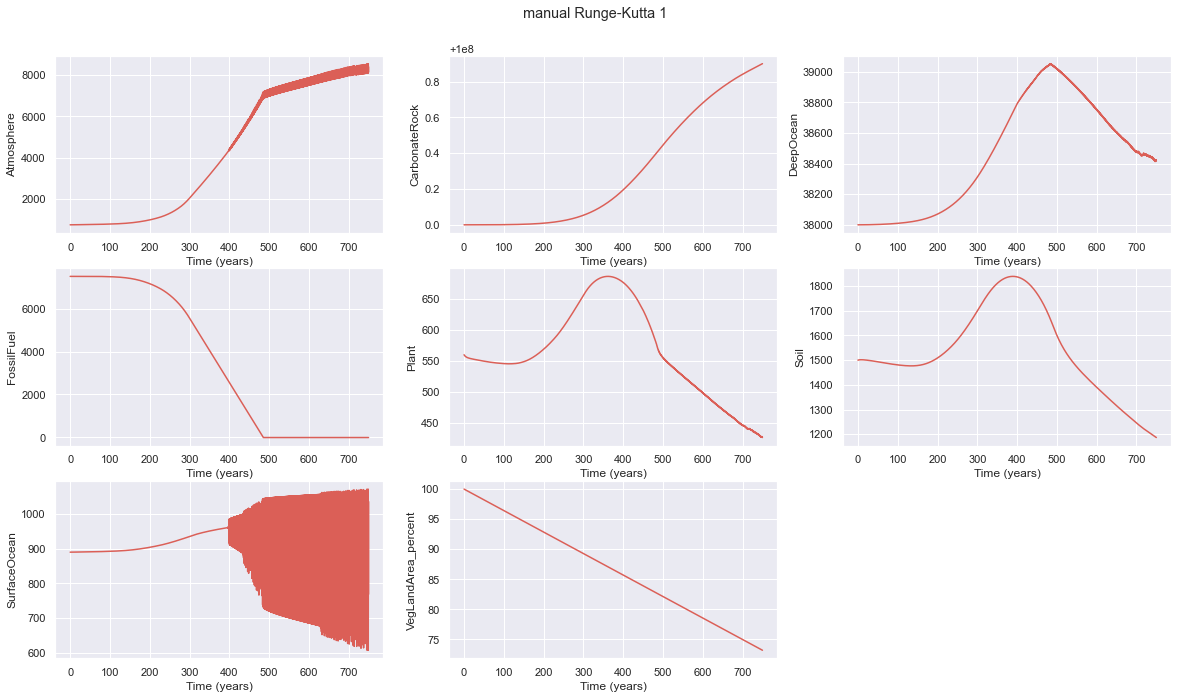

In [125]:
model.predict("RK1", 0, 750, num=3000)
model.plot_evolution(model.params, title="manual Runge-Kutta 1")

> Ici, il est clair que notre hypothèse de continuité des fonctions "boîtes noires" $y_0$ et $y_6$ – qui sont en fait estimées en même temps que les autres paramètres, et dépendant de ceux-ci avec des boucles de rétro-action ! – atteint ses limites. La méthode d'Euler explicite avec un pas similaire à plus haut échoue pour `SurfaceOcean` (instabilité forte). Pour `Atmsosphere`, ce n'est pas super non plus, alors qu'avant ça semblait correct. Cela a des répercussions sur les autres variables vers la fin : voir notamment `Plant` et `DeepOcean`.

Ci-dessous les courbes produites par l'outil de ISEE Systems. Visuellement, les résultats sont concluants et en accord avec notre approche.
Notons cepandant :
- autour de l'année 485, le simulateur considère la consommation de combustibles fossiles nulle (cf. le drop de la courbe rouge sur la figure du bas) alors que notre modèle prolonge par continuité la quantité par une constante au-delà de la dernière valeur entrée
- sachant qu'on ne peut pas exporter les résultats numériques du simulateur, la comparaison se restreint à être visuelle donc assez qualitative

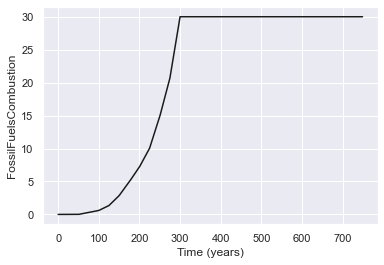

In [133]:
t = np.arange(0, 750, 1)
ffc = [FossilFuelsCombustion(_) for _ in t]
plt.plot(t, ffc, 'k')
plt.xlabel("Time (years)")
plt.ylabel("FossilFuelsCombustion")
plt.show()

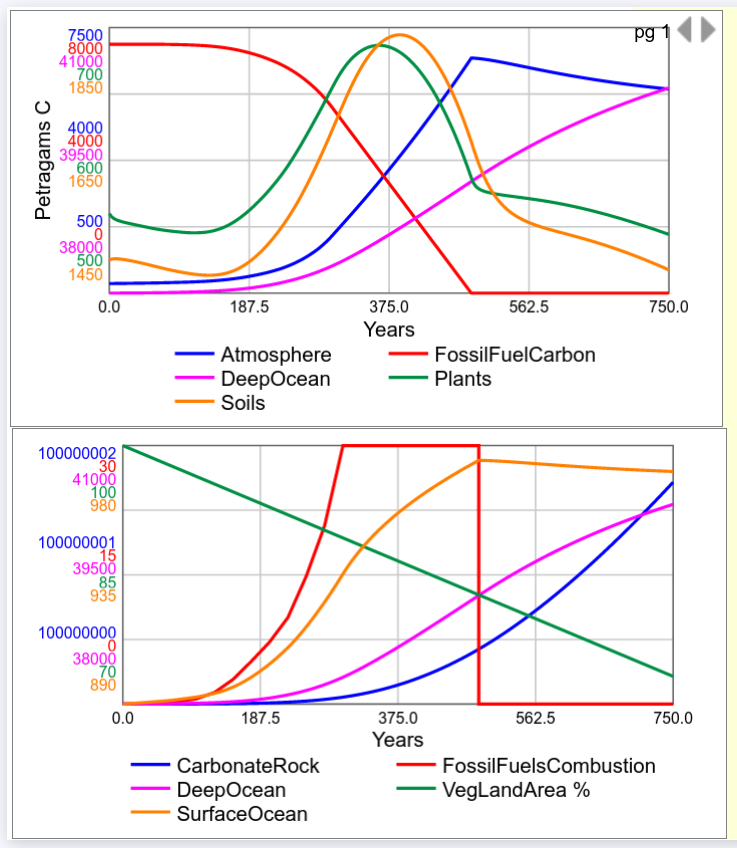

In [126]:
Image("isee_results.png", width=700, embed=True)

# Études supplémentaires

## Erreur en fonction de la taille du pas

In [158]:
# calcul d'une solution référence (hypothétiquement) très précise
model.predict("RK4", 0, 750, num=300_000)
ref = model.y

In [159]:
def errors(y):
    errors = []
    T = int(ref.shape[1] / y.shape[1])
    for i in range(y.shape[0]):
        temp = ref[i][::T]
        error = np.linalg.norm(y[i] - temp)
        errors.append(error)
    return errors

In [161]:
# test de calcul d'erreurs
model.predict("RK4", 0, 750, num=3000)
errors(model.y)

[9309.429400264224,
 2.184899275982602,
 6574.981403967404,
 161.3820088245508,
 325.6094975644343,
 799.0152644794878,
 1664.9713314078915,
 0.2795470352421377]

In [208]:
ERK4    = []
timeRK4 = []
ERK2    = []
timeRK2 = []
ERK1    = []
timeRK1 = []
nums = [3750,4000,5000,6000,6250,7500,9375,10000,12000,12500,15000,18750,20000,25000,30000,37500,50000,60000,75000,100000,150000,300000]

for num in nums:
    
    ti = time.time()
    model.predict("RK4", 0, 750, num=num)
    tf = time.time()
    ERK4.append(errors(model.y))
    timeRK4.append(tf - ti)
    
    ti = time.time()
    model.predict("RK2", 0, 750, num=num)
    tf = time.time()
    ERK2.append(errors(model.y))
    timeRK2.append(tf - ti)
    
    ti = time.time()
    model.predict("RK1", 0, 750, num=num)
    tf = time.time()
    ERK1.append(errors(model.y))
    timeRK1.append(tf - ti)
    
    print(f"fini num={num}")

fini num=3750
fini num=4000
fini num=5000
fini num=6000
fini num=6250
fini num=7500
fini num=9375
fini num=10000
fini num=12000
fini num=12500
fini num=15000
fini num=18750
fini num=20000
fini num=25000
fini num=30000
fini num=37500
fini num=50000
fini num=60000
fini num=75000
fini num=100000
fini num=150000
fini num=300000


In [234]:
ERK4_arr = np.array(ERK4)
ERK2_arr = np.array(ERK2)
ERK1_arr = np.array(ERK1)
h = (750-0) / np.array(nums)

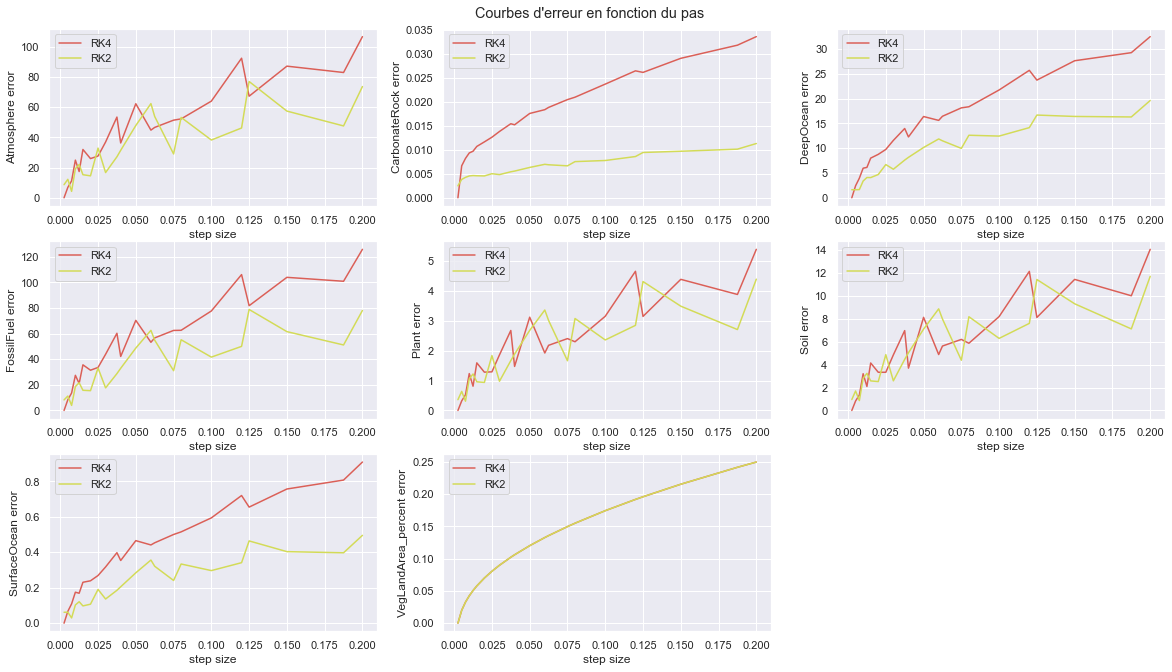

In [237]:
total = 8
cols = 3
rows = total // cols
rows += total % cols
position = range(1, total+1)
width = 20
height = 5 * (1 + ((8-1) // 3))
figsize = (width, height)
fig = plt.figure(figsize=figsize)
fig.suptitle("Courbes d'erreur en fonction du pas", y=0.9)
for k in range(8):
    ax = fig.add_subplot(rows, cols, position[k])
    ax.plot(h, ERK4_arr[:,k], label="RK4")
    ax.plot(h, ERK2_arr[:,k], label="RK2")
    ax.set_xlabel("step size")
    ax.set_ylabel(f"{model.params[k]} error")
    plt.legend()
plt.show()

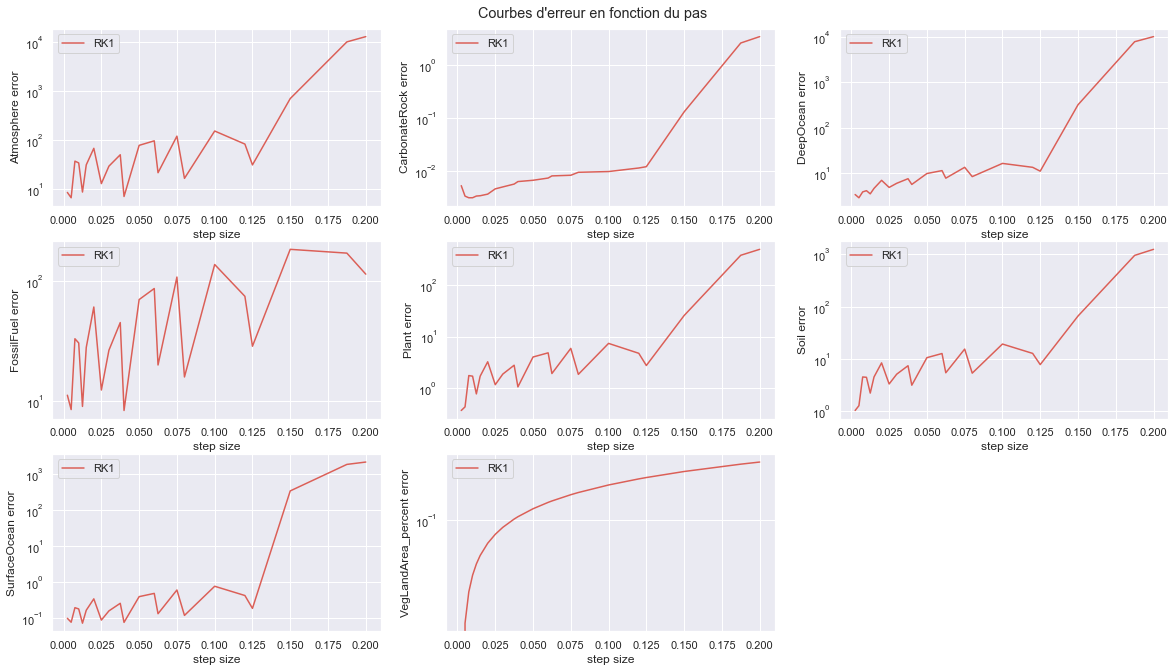

In [238]:
total = 8
cols = 3
rows = total // cols
rows += total % cols
position = range(1, total+1)
width = 20
height = 5 * (1 + ((8-1) // 3))
figsize = (width, height)
fig = plt.figure(figsize=figsize)
fig.suptitle("Courbes d'erreur en fonction du pas", y=0.9)
for k in range(8):
    ax = fig.add_subplot(rows, cols, position[k])
    ax.plot(h, ERK1_arr[:,k], label="RK1")
    ax.set_xlabel("step size")
    ax.set_ylabel(f"{model.params[k]} error")
    ax.set_yscale("log")
    plt.legend()
plt.show()

> On s'y attendait, plus le pas est petit, plus l'erreur de consistance globale est faible, et ce pour les 3 méthodes testées ici. Cependant Euler explicite (RK1) est beaucoup moins précis qu'aux ordres supérieurs pour des grands pas.

> On note le comportement intéressant pour `VegLandArea`: comme la solution exacte est affine, l'erreur de consistance globale est très régulière en fonction du pas.

## Temps de calcul en fonction de la méthode et de la taille du pas

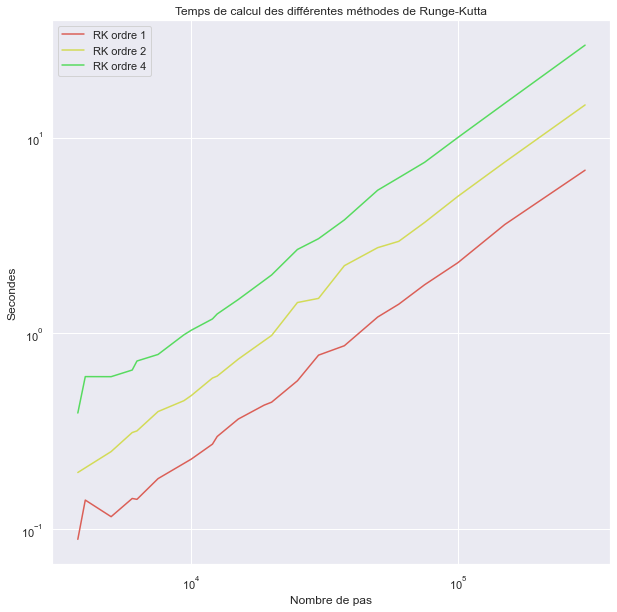

In [250]:
plt.figure(figsize=(10, 10))
plt.plot(nums, timeRK1, label='RK ordre 1')
plt.plot(nums, timeRK2, label='RK ordre 2')
plt.plot(nums, timeRK4, label='RK ordre 4')
plt.xlabel("Nombre de pas")
plt.ylabel("Secondes")
plt.xscale("log")
plt.yscale("log")
plt.title("Temps de calcul des différentes méthodes de Runge-Kutta")
plt.legend()
plt.show()

> Un des inconvénients de diminuer la taille du pas (i.e. augmenter le nombre de pas total) est évidemment l'augmentation du temps de calcul (qui est à peu près exponentielle). Il en est de même avec l'augmentation de l'ordre.

## Stabilité

In [243]:
def cst_lambda(k, a, b, h_max, q):
    alpha = 0
    sum_a = 0
    
    for i in range(q):
        for j in range(i+1):
            sum_a += abs(a[i][j])
        if (alpha<sum_a):
            alpha = sum_a
        sum_a = 0
    
    sum_k = [(alpha*k*h_max)**j for j in range (q)]
    sum_b = [np.abs(b[j])*np.sum(sum_k[:j+1]) for j in range (q)]
    return k*np.sum(sum_b) 

cst_lambda(1, [[0]], [1], 0.01, 1)

1.0

In [244]:
cst_lambda(1, [[0,0],[0.5,0]], [0.5,0.5], 0.01, 2)

1.0025

In [245]:
cst_lambda(1, [[0,0,0,0],[0.5,0,0,0],[0,0.5,0,0],[0,0,1,0]], [1/6,2/6,2/6,1/6],  0.01, 4)

1.0083834999999999